In [96]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score,classification_report,confusion_matrix



讀取CSV

In [97]:
train_df = pd.read_csv("HW2_hr-analytics_train.csv")
test_df = pd.read_csv("HW2_hr-analytics_test.csv")
train_df.head(4)

,satisfaction_level,last_evaluation,number_project,average_montly_hours,time_spend_company,Work_accident,promotion_last_5years,sales,salary,left
0,0.41,0.50,2,153,3,0,0,sales,low,1
1,0.92,0.85,5,259,5,0,0,sales,low,1
2,0.89,1.00,5,224,5,0,0,sales,low,1
3,0.45,0.54,2,135,3,0,0,sales,low,1


In [98]:
test_df.head(4)

,satisfaction_level,last_evaluation,number_project,average_montly_hours,time_spend_company,Work_accident,promotion_last_5years,sales,salary
0,0.96,0.60,3,160,10,0,0,support,medium
1,0.40,0.53,2,155,3,0,0,IT,high
2,0.48,0.93,3,219,6,0,0,technical,low
3,0.10,0.77,6,265,4,0,0,sales,low


將數字欄位的缺失值變成NaN
經過檢查，發現沒有缺失值

In [99]:
nan_col = train_df.isna().sum()  #.isna()會回傳與train.df相同大小的datafram，若是有缺失直，就會回傳True
#.sum 就是對每個column的True數目求和
nan_coltest = test_df.isna().sum()

#下面兩個方法完全一樣，可以看出哪個column有缺失值
nan_isnull = train_df.isnull().any()
nan_isna = train_df.isna().any(axis = 0)  

print(nan_col)


satisfaction_level       0
last_evaluation          0
number_project           0
average_montly_hours     0
time_spend_company       0
Work_accident            0
promotion_last_5years    0
sales                    0
salary                   0
left                     0
dtype: int64


將非數字類型進行編碼(機器學習模型通常只能處理數字。因此，需要將非數字的資料轉換成數字，才能讓模型學習。)

#### 選擇適當的編碼方式：

類別無高低關係：使用 One-Hot Encoding。但要小心資料量大會有Curse of dimensionality


類別有高低順序之分：Ordinal Encoding

e.g. 
高中 --> 1
學士 --> 2
碩士 --> 3
博士 --> 4

類別與目標變數有強相關性：Target Encoding，跟據結果來進行encpde。但需注意資料洩漏。

In [100]:
sales_class = train_df['sales'].unique()
salary_class = train_df['salary'].unique()

print("unique classes in sales:",sales_class)
print('\n')
print("unuque classes in salary:",salary_class)

unique classes in sales: ['sales' 'accounting' 'hr' 'technical' 'support' 'management' 'IT'
 'product_mng' 'marketing' 'RandD']


unuque classes in salary: ['low' 'medium' 'high']


經過上面觀察後，發現sales資料無相關性，所以使用 one hot encoding

salary 資料有相關性，所以使用label encoding

In [101]:
## one hot encoding
sales_encoded = pd.get_dummies(train_df['sales'],prefix='sales')
#for test data
sales_encodedts = pd.get_dummies(test_df['sales'],prefix='sales')


## label encoding
mapping = {'low' : 0,'medium' :1,'high' : 2}
train_df['salary_encoded' ] = train_df['salary'].map(mapping)
test_df['salary_encoded'] = test_df['salary'].map(mapping)


將encoding結束的資料寫回新的csv

In [102]:
train_df = pd.concat([train_df,sales_encoded],axis = 1)#將one hot encoding的結果整合進去train_df
test_df = pd.concat([test_df,sales_encodedts],axis = 1)#將one hot encoding的結果整合進去train_df



train_df = train_df.drop('sales',axis = 1)
train_df = train_df.drop('salary',axis = 1)


test_df = test_df.drop('sales',axis = 1)
test_df = test_df.drop('salary',axis = 1)

train_df.to_csv('encoded_train_data.csv',index= False)
test_df.to_csv('encoded_test_data.csv',index = 0)



## 綜合調整
1. 對average_montly_hours進行標準化(因為數值較大，範圍從100~300)

2. 對last_evaluation 以及 number projectc進行分箱，分成「低」、「中」、「高」三個類別。

3. 創造新特徵 efficiency，結合 average_montly_hours 和 time_spend_company ，表示員工的「工作效率」。

4. 移除promotion_last_5years


In [103]:
from sklearn.preprocessing import StandardScaler

df = pd.read_csv("encoded_train_data.csv")
test_df = pd.read_csv("encoded_test_data.csv")

# Step 1: Normalize 'average_montly_hours'
scaler = StandardScaler()
df['average_montly_hours_normalized'] = scaler.fit_transform(df[['average_montly_hours']])
test_df['average_montly_hours_normalized'] = scaler.fit_transform(test_df[['average_montly_hours']])

# Step 2 :Binning 'last_evaluation'
df['last_evaluation_binned'] = pd.cut(df['last_evaluation'], bins=3, labels=['Low', 'Medium', 'High'])
test_df['last_evaluation_binned'] = pd.cut(test_df['last_evaluation'], bins=3, labels=['Low', 'Medium', 'High'])


# Bining 'number project'
df['number_project_binned'] = pd.cut(df['number_project'],bins = 3,labels = ['Low','Medium','High'])
test_df['number_project_binned'] = pd.cut(test_df['number_project'],bins = 3,labels = ['Low','Medium','High'])

# Step 3: Create a new feature 'efficiency'
df['efficiency'] = df['average_montly_hours'] / df['time_spend_company']
test_df['efficiency'] = test_df['average_montly_hours'] / test_df['time_spend_company']


# Drop original features that have been transformed or are redundant
df = df.drop(columns=['average_montly_hours', 'last_evaluation', 'number_project','promotion_last_5years'])
test_df = test_df.drop(columns=['average_montly_hours', 'last_evaluation', 'number_project','promotion_last_5years'])

# Convert categorical features to dummy variables (create binary columns for 'low', 'medium', 'high')
# 所以進行分箱結束後會變成 categorical data ，要把它變成numerical data才能送入regression model
df = pd.get_dummies(df, columns=['last_evaluation_binned', 'number_project_binned'], drop_first=True)
test_df = pd.get_dummies(test_df, columns=['last_evaluation_binned', 'number_project_binned'], drop_first=True)

df.to_csv('final_train_data.csv',index=0)
test_df.to_csv('final_test_data.csv',index=0)
print(df.dtypes)


satisfaction_level                 float64
time_spend_company                   int64
Work_accident                        int64
left                                 int64
salary_encoded                       int64
sales_IT                              bool
sales_RandD                           bool
sales_accounting                      bool
sales_hr                              bool
sales_management                      bool
sales_marketing                       bool
sales_product_mng                     bool
sales_sales                           bool
sales_support                         bool
sales_technical                       bool
average_montly_hours_normalized    float64
efficiency                         float64
last_evaluation_binned_Medium         bool
last_evaluation_binned_High           bool
number_project_binned_Medium          bool
number_project_binned_High            bool
dtype: object


In [104]:
print(test_df.dtypes)

satisfaction_level                 float64
time_spend_company                   int64
Work_accident                        int64
salary_encoded                       int64
sales_IT                              bool
sales_RandD                           bool
sales_accounting                      bool
sales_hr                              bool
sales_management                      bool
sales_marketing                       bool
sales_product_mng                     bool
sales_sales                           bool
sales_support                         bool
sales_technical                       bool
average_montly_hours_normalized    float64
efficiency                         float64
last_evaluation_binned_Medium         bool
last_evaluation_binned_High           bool
number_project_binned_Medium          bool
number_project_binned_High            bool
dtype: object


### 建立Logistic Regression 模型進行訓練。(為了方便等等比較)
並呈現混淆矩陣。

Model Accuracy: 0.87
confusion matrix:
 [[1420   98]
 [ 154  328]]
AUC score: 0.93
Classification Report:
              precision    recall  f1-score   support

           0       0.90      0.94      0.92      1518
           1       0.77      0.68      0.72       482

    accuracy                           0.87      2000
   macro avg       0.84      0.81      0.82      2000
weighted avg       0.87      0.87      0.87      2000


Feature Importance:
                             Feature  Importance
14  average_montly_hours_normalized    3.457136
1                time_spend_company   -2.664855
16    last_evaluation_binned_Medium   -2.580812
0                satisfaction_level   -2.343813
2                     Work_accident   -1.540619
5                       sales_RandD   -0.699255
18     number_project_binned_Medium   -0.635926
3                    salary_encoded   -0.628152
17      last_evaluation_binned_High   -0.519601
7                          sales_hr    0.270807
15               

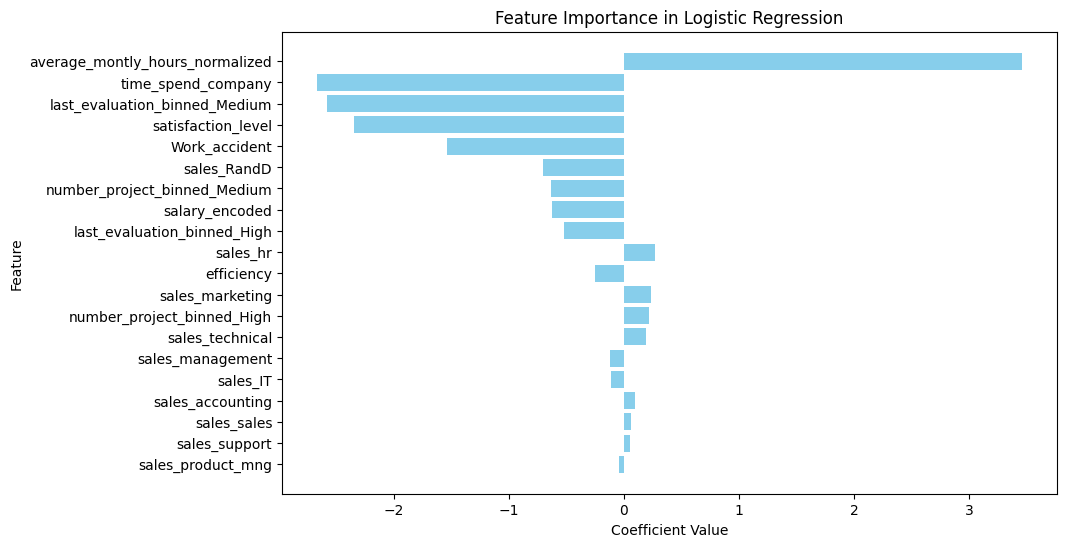

In [105]:
from sklearn.metrics import roc_auc_score

df = pd.read_csv('final_train_data.csv')


# Define feature columns and target
X = df.drop(columns=['left'])  # Assuming 'left' is the target variable
y = df['left']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize and train the Logistic Regression model
model = LogisticRegression(max_iter=1000)
model.fit(X_train, y_train)

# Make predictions
y_pred = model.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print(f"Model Accuracy: {accuracy:.2f}")

conf_matrix = confusion_matrix(y_test,y_pred)
print(f"confusion matrix:\n {conf_matrix}")

# Make predictions and calculate AUC
y_pred_proba = model.predict_proba(X_test)[:, 1]
auc_score = roc_auc_score(y_test, y_pred_proba)

print(f"AUC score: {auc_score:.2f}")

class_report = classification_report(y_test, y_pred)
print(f"Classification Report:\n{class_report}")

# 特徵重要性分析（係數）
feature_importance = model.coef_[0]  # 邏輯迴歸的係數
features = X.columns

# 整理並排序特徵重要性
importance_df = pd.DataFrame({'Feature': features, 'Importance': feature_importance})
importance_df['Absolute Importance'] = np.abs(importance_df['Importance'])  # 用絕對值來排序
importance_df = importance_df.sort_values(by='Absolute Importance', ascending=False)

print("\nFeature Importance:\n", importance_df[['Feature', 'Importance']])

# 視覺化特徵重要性
plt.figure(figsize=(10, 6))
plt.barh(importance_df['Feature'], importance_df['Importance'], color='skyblue')
plt.xlabel("Coefficient Value")
plt.ylabel("Feature")
plt.title("Feature Importance in Logistic Regression")
plt.gca().invert_yaxis()
plt.show()

### dicition tree 進行訓練
呈現混淆矩陣。

In [106]:
from sklearn.tree import DecisionTreeClassifier


df = pd.read_csv('final_train_data.csv')

#分離X以及Y
x = df.drop('left',axis = 1)
y = df['left']

#分離測試資料
X_train,X_test,y_train,y_test = train_test_split(x,y,test_size = 0.2,random_state = 42)

treemodel = DecisionTreeClassifier()
treemodel.fit(X_train,y_train)

y_pred = treemodel.predict(X_test)

#評估accuracy
accuracy = accuracy_score(y_test,y_pred)
print(f"Accuracy:{accuracy}")

#建立混淆矩陣
conf_matrix = confusion_matrix(y_test,y_pred)
print(f"confusion matrix:\n {conf_matrix}")


class_report = classification_report(y_test, y_pred)
print(f"Classification Report:\n{class_report}")




Accuracy:0.973
confusion matrix:
 [[1495   23]
 [  31  451]]
Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.98      0.98      1518
           1       0.95      0.94      0.94       482

    accuracy                           0.97      2000
   macro avg       0.97      0.96      0.96      2000
weighted avg       0.97      0.97      0.97      2000



### 利用訓練後的模型預測測試資料HW2_hr-analytics_test.csv的離職情況


In [107]:
test_df = pd.read_csv("final_test_data.csv")
y_pred = treemodel.predict(test_df)

save_df = pd.DataFrame(y_pred,columns = ['left'])
print(save_df.head(5))

save_df.to_csv('HW2_hr-analytics_test_sol.csv',index =False)

   left
0     0
1     0
2     1
3     1
4     0


## 探討與decision tree與logistic regression的適合度及原因

### 先看看logistic regression 的原理

logistic is a linear combination of the features

(e.g. x1 = satisfaction_level, x2 = time_spend_company)

z = w1x1 + w2x2 + ... + wnxn

w is weight to ve learned

z is the linear score for this input data(one row in the csv)

then we pass z through a sigmoid function,The output 

𝜎(𝑧)

represents the probability that the input data point belongs to the positive class(left = 1) 

so we make a prediction based on the 𝜎(𝑧),if it >= 0.5 , we predeic left = 1

### 再看看decision tree

it use different features(e.g. satisfaction_level,time_spend_company) as the trees nodes,

the prediction is down by split one data from root to leaf,based on the feature values



After all splits are made, each leaf node ends up with a group of data points that have similar characteristics.(e.g  satisfaction_level < 0.5  and time_spend_company > 3)

Each leaf node represents a final class label (like left = 1 or left = 0).

the label is determined by looking at the majority class in that leaf node during training.

### 比較
1.  accuracy

    Decision Tree:99.95%

    Logistic Regression:87% ,     with a slightly lower performance on class 1 

            (recall of 68% for class 1)

2. confusion matrix

    Decision Tree: With only one false positive

    Logistic Regression: hard to classify class 1 (152 false negatives). 

### 探討 

    a. decision tree 比較適合捕捉non linear特性，透過不同的feature以及thresholds來分類，而logistic regression只用一條一次方的直線(or 平面)來區分兩個類別，對於非線性的資料可能較難預測。
    
    b.decision tree結果很漂亮，但是可能導致overfitting


    根據資料本身
    left = 0樣本數量 (1518) 遠遠多於left = 1樣本數量 (482)，所以模型較難分辨left


### 結論
    
    a. 如果想要理解模型：logistic regression可以看到每個feature 訓練出的weight，能幫助我們理解哪些特徵才是重要的，但decision tree也可以使用套件做到這一點。

    b. 如果想要提高泛化能力：雖然decition tree的高準確率更可能overfitting，但是經過測試，不同的train test split，都能達到很高的準確度。

    c. 類別不平衡:從結果來看，decision tree能很好的面對這類問題，如果沒有做額外的資料擴增，選擇decision tree或許能改善資料不平衡的問題。

    d.追求accuracy:那就選擇decision tree。


    總體來說，我會選擇使用decision tree作為離職率預測的模型，因為經過測試，不論train test split 從0.1 到0.9，decision tree都保持98%以上的高準確度，因此具有很好的泛化、accuracy，處理不平衡訓練資料的能力，而且因為類別不多，也可以幫助查看哪些才是重要的特徵。

## decision tree特徵重要性分析


Feature Importance:
                             Feature  Importance
0                satisfaction_level    0.406440
15                       efficiency    0.188327
1                time_spend_company    0.154407
18     number_project_binned_Medium    0.112365
14  average_montly_hours_normalized    0.051502
17      last_evaluation_binned_High    0.038163
16    last_evaluation_binned_Medium    0.026070
3                    salary_encoded    0.006011
13                  sales_technical    0.003448
2                     Work_accident    0.002448
19       number_project_binned_High    0.002388
12                    sales_support    0.002077
11                      sales_sales    0.001768
6                  sales_accounting    0.001032
4                          sales_IT    0.000832
8                  sales_management    0.000817
10                sales_product_mng    0.000661
7                          sales_hr    0.000634
9                   sales_marketing    0.000425
5                 

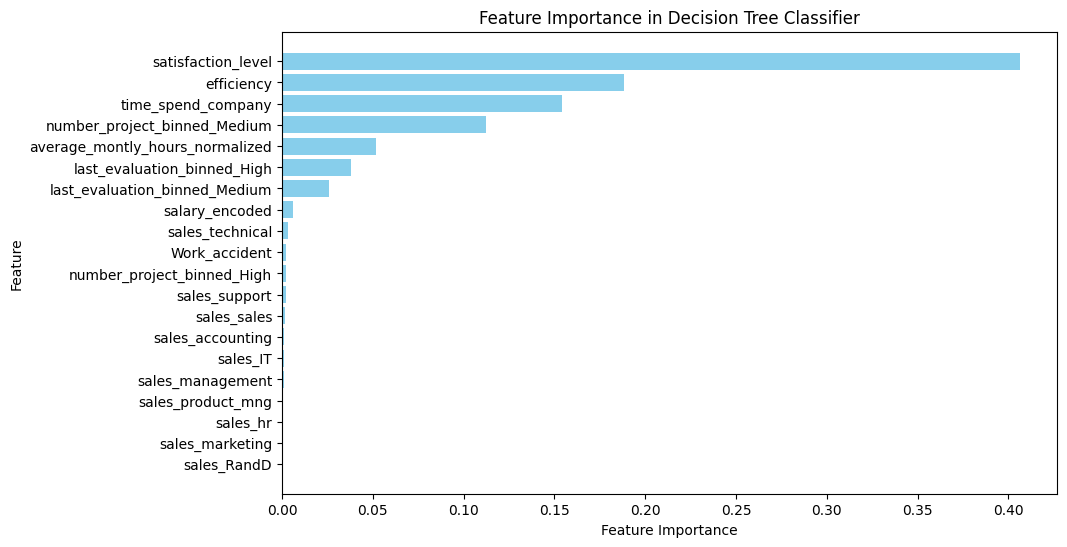

In [108]:
# 特徵重要性分析
feature_importances = treemodel.feature_importances_
features = x.columns

# 將特徵重要性結果整理為 DataFrame
importance_df = pd.DataFrame({'Feature': features, 'Importance': feature_importances})
importance_df = importance_df.sort_values(by='Importance', ascending=False)

print("\nFeature Importance:\n", importance_df)

# 視覺化特徵重要性
plt.figure(figsize=(10, 6))
plt.barh(importance_df['Feature'], importance_df['Importance'], color='skyblue')
plt.xlabel("Feature Importance")
plt.ylabel("Feature")
plt.title("Feature Importance in Decision Tree Classifier")
plt.gca().invert_yaxis()
plt.show()


根據之前的結果，satisfaction_level 和 efficiency 是相對重要的特徵。

### 基於這兩個特徵訓練一個模型

並繪製ROC、決策圖 

AUC Score: 0.95


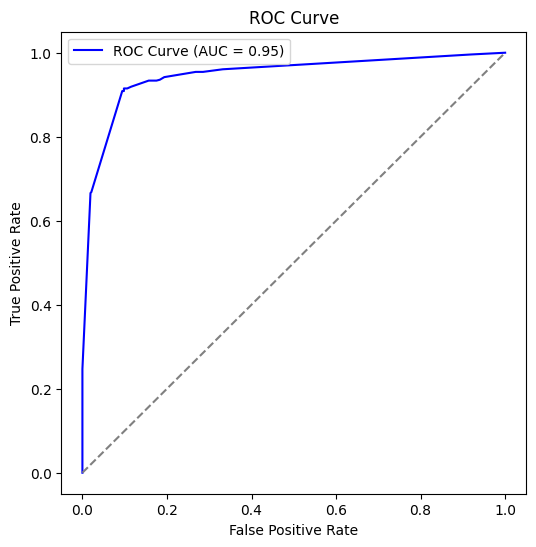

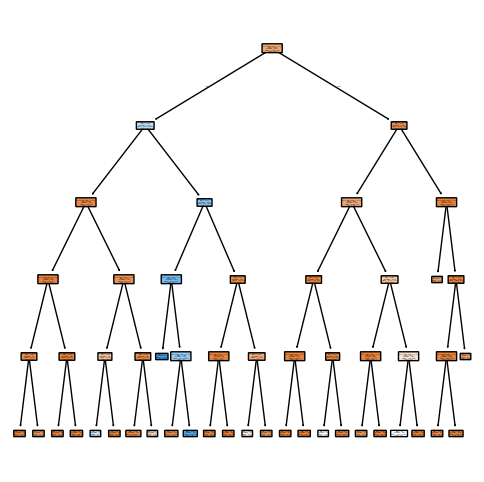

In [110]:
from sklearn.tree import DecisionTreeClassifier, plot_tree
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, roc_curve
import matplotlib.pyplot as plt

# Load data
df = pd.read_csv('final_train_data.csv')

# Select the two most important features
X = df[['satisfaction_level', 'efficiency']]
y = df['left']

# Split the dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train decision tree model with depth limitation and pruning parameters
tmodel = DecisionTreeClassifier(max_depth=5, min_samples_split=10, min_samples_leaf=5, random_state=42)
tmodel.fit(X_train, y_train)

# Predict probabilities
y_pred_proba = tmodel.predict_proba(X_test)[:, 1]

# Calculate AUC and plot ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
auc_score = roc_auc_score(y_test, y_pred_proba)
print(f"AUC Score: {auc_score:.2f}")

plt.figure(figsize=(6, 6))
plt.plot(fpr, tpr, color='blue', label=f"ROC Curve (AUC = {auc_score:.2f})")
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.show()

# Plot simplified decision tree
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(6, 6), dpi=100)
plot_tree(
    tmodel,
    feature_names=['satisfaction_level', 'efficiency'],
    class_names=['stay', 'left'],
    filled=True,
    rounded=True
)
plt.show()
